# Calculate Search Metrics with Dynamic Optimizer

This notebook loads the models that were built in the previous notebook and test how much the queries improve when using a pipeline with the predicted "neuralness" value.

1. Get the models
2. Get the queries
3. Get the ratings file
4. Get the predicted "neuralness" scores for each query from each model
5. Run the queries (two runs per query; one per model)
    1. Create the pipeline with the according "neuralness" and "keywordness" values
    2. Run the query once per model type
    3. Store the results
7. Calculate search metrics
8. Compare search metrics with the best metrics of the notebook that explored all hybrid search configurations 

In [1]:
import pickle
import pandas as pd
import requests
import json
import uuid
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm_notebook

## Load models from the previous notebook

In [50]:
# load the two models
with open('regression_model_predict_only_max_ndcg_large_qs-2024-12-03_DCG_fix.pkl', 'rb') as fid:
    regr = pickle.load(fid)

with open('random_forest_model_predict_only_max_ndcg_large_qs-2024-12-03_DCG_fix.pkl', 'rb') as fid:
    random_forest = pickle.load(fid)

In [51]:
regr

Ridge(alpha=0.001)

In [52]:
random_forest

RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50, random_state=42)

In [53]:
df_test_data = pd.read_csv('../data/dynamic_optimizer_large_qs_test_data-2024-12-03_DCG_fix.csv')

In [54]:
df_test_data.head(5)

,query_string,ndcg,f_0_neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
0,- we are not such things,0.631793,0.8,6,24,0,1,435,3.378685,4.655999,0.531436,0.492488
1,02cool spray water bottle for drinking not fla...,0.156796,1.0,10,56,1,0,0,0.000000,0.000000,0.535250,0.524388
2,0pi nail polish i'm not really a waitress,0.146379,1.0,8,41,1,1,0,0.000000,0.000000,0.669153,0.605961
3,1 14 brown leather belt without buckle,0.055075,0.9,7,38,1,0,1,0.523058,0.523058,0.664045,0.648673
4,1 flexible 8x10 mirror not sheet,0.067484,1.0,6,32,1,0,0,0.000000,0.000000,0.575125,0.554652


In [55]:
# Get all ratings
DATA_DIR = '/Users/danielwrigley/work/Testing/git_repos/esci-data/shopping_queries_dataset/'

In [56]:
df_examples = pd.read_parquet(DATA_DIR + '/shopping_queries_dataset_examples.parquet')

In [57]:
# Select judgments
# Map esci_label to score
# create judgments per day in range
# create noise in score

label_num = {"E": 0, "S": 1, "C": 2, "I": 3}
label_score = [3, 2, 1, 0]
#label_score = [1, 0.1, 0.01, 0]

def label_to_score(label):
    return label_score[label_num[label]]

df_ratings = df_examples[df_examples["query"].isin(set(df_test_data["query_string"].values))].copy()
df_ratings["judgment"] = df_ratings.esci_label.apply(lambda x: label_to_score(x))
df_ratings["document"] = df_ratings.product_id
df_ratings = df_ratings[["query", "document", "judgment"]].reset_index(drop=True)
df_ratings.head(3)

,query,document,judgment
0,- we are not such things,1544341156,0
1,- we are not such things,1736413902,0
2,- we are not such things,1543971679,0


In [58]:
df_test_data.shape[0]

1000

## Predict the "neuralness" with both models

In [59]:
regr.feature_names_in_

array(['f_0_neuralness', 'f_1_num_of_terms', 'f_4_has_special_char',
       'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores',
       'f_8_max_semantic_score', 'f_9_avg_semantic_score'], dtype=object)

In [60]:
random_forest.feature_names_in_

array(['f_0_neuralness', 'f_1_num_of_terms', 'f_2_query_length',
       'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score',
       'f_8_max_semantic_score', 'f_9_avg_semantic_score'], dtype=object)

In [61]:
feature_columns_lr = regr.feature_names_in_
feature_columns_rf = random_forest.feature_names_in_
def get_linear_model_prediction(row):
    df_row = pd.DataFrame([row[feature_columns_lr]], columns=feature_columns_lr)
    return regr.predict(df_row)[0]

def get_random_forest_prediction(row):
    df_row = pd.DataFrame([row[feature_columns_lr]], columns=feature_columns_rf)
    return random_forest.predict(df_row)[0]

In [62]:
# make predictions with the two models ensuring that the minimum is not below 0 and the maximum not above 1

df_test_data['linear_model'] = df_test_data.apply(
    lambda row: min(np.max(get_linear_model_prediction(row), 0), 1), axis=1
)

df_test_data['random_forest'] = df_test_data.apply(
    lambda row: min(np.max(get_random_forest_prediction(row), 0), 1), axis=1
)

In [63]:
df_test_data.head(25)

,query_string,ndcg,f_0_neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score,linear_model,random_forest
0,- we are not such things,0.631793,0.8,6,24,0,1,435,3.378685,4.655999,0.531436,0.492488,0.319165,0.324246
1,02cool spray water bottle for drinking not fla...,0.156796,1.0,10,56,1,0,0,0.000000,0.000000,0.535250,0.524388,0.155112,0.084030
2,0pi nail polish i'm not really a waitress,0.146379,1.0,8,41,1,1,0,0.000000,0.000000,0.669153,0.605961,0.267422,0.219044
3,1 14 brown leather belt without buckle,0.055075,0.9,7,38,1,0,1,0.523058,0.523058,0.664045,0.648673,0.221191,0.359539
4,1 flexible 8x10 mirror not sheet,0.067484,1.0,6,32,1,0,0,0.000000,0.000000,0.575125,0.554652,0.183234,0.126494
5,1 morton sea salt without iodine,0.052346,1.0,6,32,1,0,0,0.000000,0.000000,0.711309,0.647879,0.260664,0.280282
6,1-8x scope,0.252659,0.9,2,10,1,1,7,0.609082,1.197299,0.566155,0.541321,0.243442,0.519390
7,1/2 in air hose reel 100 ft retractable withou...,0.193892,0.0,10,52,1,1,0,0.000000,0.000000,0.683102,0.656809,0.402731,0.215239
8,10 inch bookshelf,0.000000,1.0,3,17,1,0,25,1.290947,3.910879,0.631791,0.606790,0.218423,0.103974
9,10 magnetic eyelashes without eyeliner,0.384439,0.3,5,38,1,0,21,1.052946,2.828794,0.743434,0.729628,0.348432,0.401115


In [64]:
# Get the neuralness value for the best NDCG per query
indexes_linear_model = df_test_data.groupby(by='query_string',)['linear_model'].idxmax()
df_test_data_max_ndcg_linear_model = df_test_data.loc[indexes_linear_model][['query_string','f_0_neuralness']]
# only keep query, neuralness and the information if the linear or random forest model predicted the value
df_test_data_max_ndcg_linear_model['model'] = "linear_model"

indexes_rf_model = df_test_data.groupby(by='query_string',)['random_forest'].idxmax()
df_test_data_max_ndcg_rf_model = df_test_data.loc[indexes_rf_model][['query_string','f_0_neuralness']]
df_test_data_max_ndcg_rf_model['model'] = "random_forest"
# merge the two DataFrames
df_test_data_max_ndcg = pd.concat([df_test_data_max_ndcg_linear_model, df_test_data_max_ndcg_rf_model])

## The NDCG values differ but the according neuralness value not

In [65]:
df_test_data_max_ndcg_rf_model.sort_values(by='query_string').head(20)

,query_string,f_0_neuralness,model
0,- we are not such things,0.8,random_forest
1,02cool spray water bottle for drinking not fla...,1.0,random_forest
2,0pi nail polish i'm not really a waitress,1.0,random_forest
3,1 14 brown leather belt without buckle,0.9,random_forest
4,1 flexible 8x10 mirror not sheet,1.0,random_forest
5,1 morton sea salt without iodine,1.0,random_forest
6,1-8x scope,0.9,random_forest
7,1/2 in air hose reel 100 ft retractable withou...,0.0,random_forest
8,10 inch bookshelf,1.0,random_forest
9,10 magnetic eyelashes without eyeliner,0.3,random_forest


In [66]:
df_test_data_max_ndcg.sort_values(by='query_string').head(20)

,query_string,f_0_neuralness,model
0,- we are not such things,0.8,linear_model
0,- we are not such things,0.8,random_forest
1,02cool spray water bottle for drinking not fla...,1.0,linear_model
1,02cool spray water bottle for drinking not fla...,1.0,random_forest
2,0pi nail polish i'm not really a waitress,1.0,linear_model
2,0pi nail polish i'm not really a waitress,1.0,random_forest
3,1 14 brown leather belt without buckle,0.9,linear_model
3,1 14 brown leather belt without buckle,0.9,random_forest
4,1 flexible 8x10 mirror not sheet,1.0,linear_model
4,1 flexible 8x10 mirror not sheet,1.0,random_forest


In [67]:
df_test_data_max_ndcg.shape[0]

2000

## Run the queries of the test set

* Retrieve the model id
* For each query term of the test set:
  * Create the pipeline with the predicted "neuralness" value and the calculated "keywordness" value (`1-"neuralness"`)
  * Run the query once per model type

In [69]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one

headers = {
    'Content-Type': 'application/json'
}

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
   
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [71]:
#models = ['linear_model', 'random_forest']
df_relevance = pd.DataFrame()

# iterate over all query strings, create a pipeline with the predicted "neuralness"
# and send a hybrid search query to OpenSearch with the set pipeline

#for query in tqdm_notebook(df_test_data_max_ndcg.itertuples()):
for query in tqdm_notebook(df_test_data_max_ndcg.itertuples()):
    neuralness = query[2]
    neuralness = round(neuralness, 2)
    keywordness = 1 - neuralness   
    # Set pipeline 
    url = "http://localhost:9200/ecommerce/_search"
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ]
      },
      "query": {
        "hybrid": {
          "queries": [
            {
              "multi_match" : {
                  "type":       "best_fields",
                  "fields":     [
                    "product_id^100",
                    "product_bullet_point^3",
                    "product_color^2",
                    "product_brand^5",
                    "product_description",
                    "product_title^10"
                  ],
                  "operator":   "and",
                  "query":      query[1]
                }
            },
            {
              "neural": {
                "title_embedding": {
                  "query_text": query[1],
                  "k": 100
                }
              }
            }
          ]
        }
      },
        "search_pipeline": {
          "request_processors": [
            {
              "neural_query_enricher" : {
                "description": "one of many search pipelines for experimentation",
                "default_model_id": model_id,
                "neural_field_default_id": {
                   "title_embeddings": model_id
                }
              }
            }
          ],
          "phase_results_processors": [
            {
              "normalization-processor": {
                "normalization": {
                  "technique": "l2"
                },
                "combination": {
                  "technique": "arithmetic_mean",
                  "parameters": {
                    "weights": [
                      keywordness,
                      neuralness
                    ]
                  }
                }
              }
            }
          ]    
        },
      "size": 100
    }

    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    # store results per model and pipeline
    position = 0
    if response['hits']['total']['value'] > 0:
        for hit in response['hits']['hits']:
            # create a new row for the DataFrame and append it
            row = { 'query_id' : str(query[0]), 'query_string': query[1], 'product_id' : hit["_id"], 'position' : str(position), 'relevance' : hit["_score"], 'run': query[3], 'neuralness': neuralness }
    
            new_row_df = pd.DataFrame([row])
            df_relevance = pd.concat([df_relevance, new_row_df], ignore_index=True)
            position += 1
    else:
        print(f"No results for query {query[1]}")
        
    # work with two for loops:
    # 1) one to iterate over the list of queries and have a query id instead of a query
    # 2) another one to iterate over the result sets to have the position of the result in the result set 
    
    # DataFrame is created using some of TREC's namings for the evaluation tools:
    # query_id: the id of the query as the trec_eval tool needs a numeric id rather than a query string as an identifier
    # query_string: the user query
    # product_id: the id of the product in the hit list
    # position: the position of the product in the result set
    # relevance: relevance as given by the search engine
    # run: the name of the model used to predict the neuralness of the model
    # neuralness: the predicted neuralness of the query

0it [00:00, ?it/s]

In [72]:
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,- we are not such things,0812994507,0,0.134212,linear_model,0.8
1,0,- we are not such things,B00L4B5MWA,1,0.092974,linear_model,0.8
2,0,- we are not such things,B08VJM1568,2,0.089573,linear_model,0.8


In [73]:
df_ratings.head(3)

,query,document,judgment
0,- we are not such things,1544341156,0
1,- we are not such things,1736413902,0
2,- we are not such things,1543971679,0


In [74]:
df_ratings.columns = ['query_string', 'product_id', 'rating']
df_ratings.head(3)

,query_string,product_id,rating
0,- we are not such things,1544341156,0
1,- we are not such things,1736413902,0
2,- we are not such things,1543971679,0


In [75]:
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,- we are not such things,0812994507,0,0.134212,linear_model,0.8
1,0,- we are not such things,B00L4B5MWA,1,0.092974,linear_model,0.8
2,0,- we are not such things,B08VJM1568,2,0.089573,linear_model,0.8


In [76]:
# Make sure ids are strings, positions are integers - otherwise the merge operation or the metrics calculation might cause an error
df_relevance['query_id'] = df_relevance['query_id'].astype(str)
df_relevance['position'] = df_relevance['position'].astype(int)
# Remove duplicates from the ratings DataFrame
df_unique_ratings = df_ratings.drop_duplicates(subset=['product_id', 'query_string'])

In [77]:
# Merge results on query_string and product_id so that the resulting DataFrame has the ratings together with the search results
# Merge on query_string instead of query_id because the df_relevance query_ids are not the ones originating from the ratings.
# Validations helps us make sure that we have only one rating for each query-doc pair. We have identical query-doc pairs per
# search pipeline but we can only have one rating for these.

df_merged = df_relevance.merge(df_unique_ratings, on=['query_string', 'product_id'], how='left', validate='many_to_one')
# remove unnecessary information and rename columns

df_merged.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,- we are not such things,0812994507,0,0.134212,linear_model,0.8,3.0
1,0,- we are not such things,B00L4B5MWA,1,0.092974,linear_model,0.8,NaN
2,0,- we are not such things,B08VJM1568,2,0.089573,linear_model,0.8,NaN


In [78]:
# Count the rows without ratings - the higher the count is the less reliable the results will be
nan_count_rating = df_merged['rating'].isna().sum()
print(f"There are {df_merged.shape[0]} rows and {nan_count_rating} do not contain a rating among the 100 returned results per query")
nan_count_rating_top_10 = df_merged[df_merged['position'] < 10]['rating'].isna().sum()
print(f"{nan_count_rating_top_10} do not contain a rating among the top 10 returned results per query")

There are 200000 rows and 187392 do not contain a rating among the 100 returned results per query
13904 do not contain a rating among the top 10 returned results per query


In [79]:
df_merged[df_merged['position'] < 10].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,- we are not such things,0812994507,0,0.134212,linear_model,0.8,3.0
1,0,- we are not such things,B00L4B5MWA,1,0.092974,linear_model,0.8,NaN
2,0,- we are not such things,B08VJM1568,2,0.089573,linear_model,0.8,NaN
3,0,- we are not such things,B07RWSH4BP,3,0.089492,linear_model,0.8,NaN
4,0,- we are not such things,B08WRDMYTH,4,0.086700,linear_model,0.8,2.0
5,0,- we are not such things,B08TV3XGZ4,5,0.084785,linear_model,0.8,NaN
6,0,- we are not such things,B07MRKPHKR,6,0.084785,linear_model,0.8,NaN
7,0,- we are not such things,1937578313,7,0.083930,linear_model,0.8,NaN
8,0,- we are not such things,B078JNBVFY,8,0.083930,linear_model,0.8,NaN
9,0,- we are not such things,035813143X,9,0.082817,linear_model,0.8,NaN


In [80]:
# import from shared utils file metrics.py
from utils import metrics

metrics = [
    ("dcg", metrics.dcg_at_10, None),
    ("ndcg", metrics.ndcg_at_10, None),
    ("prec@10", metrics.precision_at_k, None),
    ("ratio_of_ratings", metrics.ratio_of_ratings, None)
]

## Calculate Metrics per Query and Model

In [81]:
reference = {query: df for query, df in df_ratings.groupby("query_string")}

df_metrics = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df_merged.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics.append(pd.DataFrame({
            "query": [query_string],
            "model": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [82]:
df_metrics.head(40)

,query,model,metric,value
0,- we are not such things,linear_model,dcg,8.160558
0,- we are not such things,random_forest,dcg,8.160558
0,02cool spray water bottle for drinking not fla...,linear_model,dcg,9.853369
0,02cool spray water bottle for drinking not fla...,random_forest,dcg,9.853369
0,0pi nail polish i'm not really a waitress,linear_model,dcg,7.000000
0,0pi nail polish i'm not really a waitress,random_forest,dcg,7.000000
0,1 14 brown leather belt without buckle,linear_model,dcg,3.000000
0,1 14 brown leather belt without buckle,random_forest,dcg,3.000000
0,1 flexible 8x10 mirror not sheet,linear_model,dcg,2.446395
0,1 flexible 8x10 mirror not sheet,random_forest,dcg,2.446395


In [84]:
df_merged[(df_merged['query_string'] == '12x20 throw pillow covers set of 2') & (df_merged['run'] == 'linear_model')].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
1900,19,12x20 throw pillow covers set of 2,B091WP34CP,0,0.177265,linear_model,0.6,3.0
1901,19,12x20 throw pillow covers set of 2,B08SBPL1C6,1,0.169481,linear_model,0.6,3.0
1902,19,12x20 throw pillow covers set of 2,B09CTCCXDJ,2,0.155937,linear_model,0.6,3.0
1903,19,12x20 throw pillow covers set of 2,B09BCNW9V1,3,0.151184,linear_model,0.6,3.0
1904,19,12x20 throw pillow covers set of 2,B099JMHMMJ,4,0.142012,linear_model,0.6,3.0
1905,19,12x20 throw pillow covers set of 2,B083YTTZKD,5,0.106555,linear_model,0.6,NaN
1906,19,12x20 throw pillow covers set of 2,B07SZBJ6QJ,6,0.104808,linear_model,0.6,NaN
1907,19,12x20 throw pillow covers set of 2,B09BCQNMB6,7,0.098339,linear_model,0.6,3.0
1908,19,12x20 throw pillow covers set of 2,B07MM1WNNB,8,0.093608,linear_model,0.6,NaN
1909,19,12x20 throw pillow covers set of 2,B07XMJ4944,9,0.092513,linear_model,0.6,NaN


## Calculate Metrics per Model by Averaging the Query Metrics

In [85]:
df_metrics_per_pipeline = df_metrics.pivot_table(index="model", columns="metric", values="value", aggfunc=lambda x: x.mean().round(2))
df_metrics_per_pipeline = df_metrics_per_pipeline.reset_index()
df_metrics_per_pipeline

metric,model,dcg,ndcg,prec@10,ratio_of_ratings
0,linear_model,10.13,0.27,0.29,0.3
1,random_forest,10.13,0.27,0.29,0.3


# Compare to baseline and global hybrid search optimizer (large data set metrics)

| Metric    | Baseline BM25 | Global Hybrid Search Optimizer | Dynamic Hybrid Search Optimizer - Linear Model | Dynamic Hybrid Search Optimizer - Random Forest Model |
| -------- | ------- | ------- | ------- | ------- |
| DCG       | 8.82    | 9.30    | 10.13   | 10.13
| NDCG      | 0.23    | 0.25    | 0.27    | 0.27
| Precision | 0.24    | 0.27    | 0.29    | 0.29

In [86]:
df_global_optimization_metrics = pd.read_csv('../data/metrics_query_test_large_qs_all_pipelines-2024-12-03_DCG_fix.csv')
df_global_optimization_metrics.head(3)

,query,pipeline,metric,value
0,- we are not such things,l2arithmetic_mean0.0,dcg,1.292030
1,- we are not such things,l2arithmetic_mean0.1,dcg,1.292030
2,- we are not such things,l2arithmetic_mean0.2,dcg,8.160558


In [87]:
df_metrics_pivot = df_metrics.pivot_table(index="query", columns=["model", "metric"], values="value").reset_index()
df_metrics_pivot.columns = [" ".join(c).strip() for c in df_metrics_pivot.columns.values]
df_metrics_pivot.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings
0,- we are not such things,8.160558,0.631793,0.2,0.2,8.160558,0.631793,0.2,0.2
1,02cool spray water bottle for drinking not fla...,9.853369,0.156796,0.4,0.4,9.853369,0.156796,0.4,0.4
2,0pi nail polish i'm not really a waitress,7.000000,0.146379,0.1,0.1,7.000000,0.146379,0.1,0.1


## Get the max metric values to compare the per-query optimization approach to

In [90]:
metrics = ['dcg', 'ndcg', 'prec@10']
query = '- we are not such things'
print(f"Max metrics for the query '{query}'")
for metric in metrics:
    max_value = df_global_optimization_metrics[(df_global_optimization_metrics['query'] == query) & (df_global_optimization_metrics['metric'] == metric)]['value'].max()
    print(f"max for {metric}: {max_value}")

Max metrics for the query '- we are not such things'
max for dcg: 8.160558421703625
max for ndcg: 0.6317929155434615
max for prec@10: 0.2


In [91]:
df_global_optimization_metrics_gr = df_global_optimization_metrics.groupby(by=['query', 'metric']).agg({
    'value': 'max'
}).reset_index()
df_global_optimization_metrics_gr[df_global_optimization_metrics_gr['query'] == query]

,query,metric,value
0,- we are not such things,dcg,8.160558
1,- we are not such things,ndcg,0.631793
2,- we are not such things,prec@10,0.200000
3,- we are not such things,ratio_of_ratings,0.200000


In [92]:
df_global_optimization_metrics_pivot = df_global_optimization_metrics_gr.pivot_table(index="query", columns=["metric"], values="value").reset_index()
df_global_optimization_metrics_pivot.columns = ['query', 'dcg', 'ndcg', 'prec@10', 'ratio_of_ratings']
df_global_optimization_metrics_pivot.head(5)

,query,dcg,ndcg,prec@10,ratio_of_ratings
0,- we are not such things,8.160558,0.631793,0.2,0.2
1,02cool spray water bottle for drinking not fla...,9.853369,0.156796,0.4,0.4
2,0pi nail polish i'm not really a waitress,7.000000,0.146379,0.1,0.1
3,1 14 brown leather belt without buckle,3.000000,0.055075,0.1,0.1
4,1 flexible 8x10 mirror not sheet,2.446395,0.067484,0.2,0.3


In [93]:
df_metrics_merged = df_metrics_pivot.merge(df_global_optimization_metrics_pivot, on='query', how='left')

In [94]:
df_metrics_merged.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings,dcg,ndcg,prec@10,ratio_of_ratings
0,- we are not such things,8.160558,0.631793,0.2,0.2,8.160558,0.631793,0.2,0.2,8.160558,0.631793,0.2,0.2
1,02cool spray water bottle for drinking not fla...,9.853369,0.156796,0.4,0.4,9.853369,0.156796,0.4,0.4,9.853369,0.156796,0.4,0.4
2,0pi nail polish i'm not really a waitress,7.000000,0.146379,0.1,0.1,7.000000,0.146379,0.1,0.1,7.000000,0.146379,0.1,0.1


## Visiualization

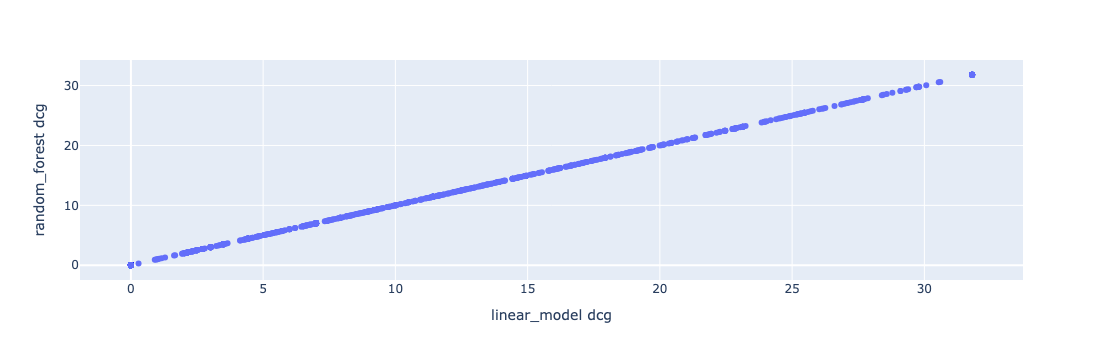

In [95]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="random_forest dcg",
    hover_data=df_metrics_merged.columns,
)

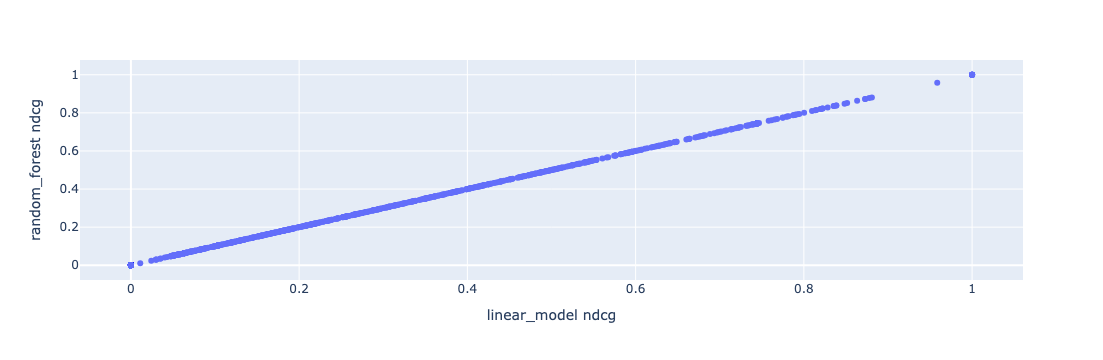

In [96]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="random_forest ndcg",
    hover_data=df_metrics_merged.columns,
)

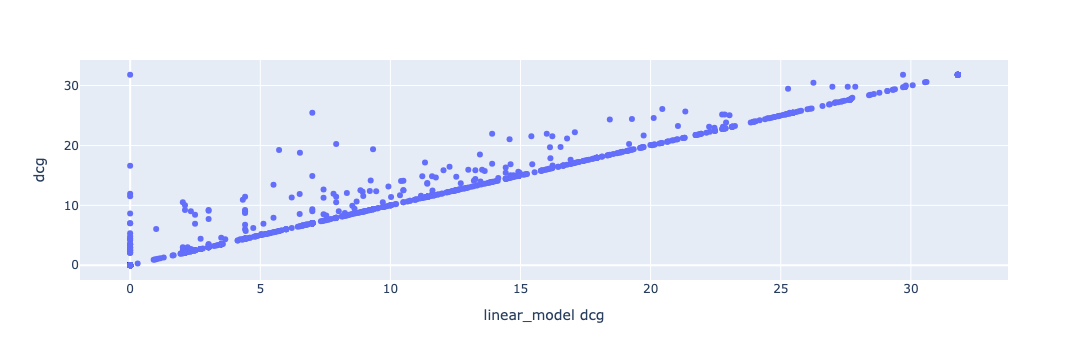

In [97]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="dcg",
    hover_data=df_metrics_merged.columns,
)

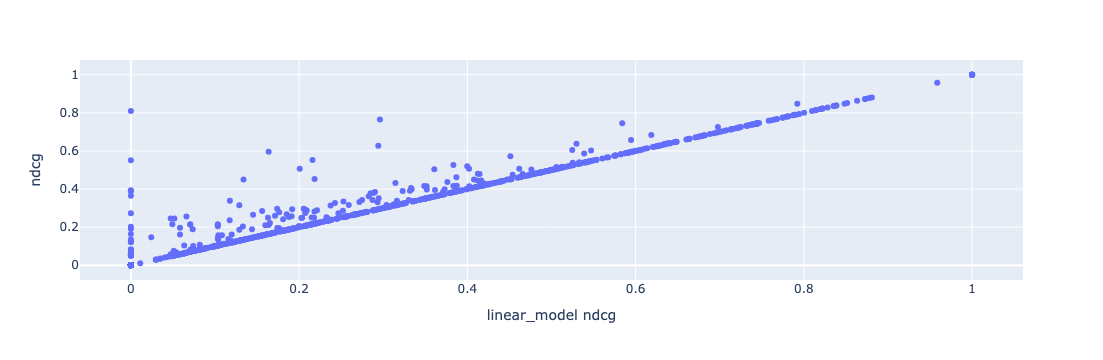

In [98]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="ndcg",
    hover_data=df_metrics_merged.columns,
)

In [99]:
df_metrics_merged['dcg_difference'] = df_metrics_merged['random_forest dcg'] - df_metrics_merged['linear_model dcg']

### Queries where the Linear model scores better:

In [100]:
df_metrics_merged[['query', 'dcg_difference','random_forest dcg','linear_model dcg']].sort_values(by='dcg_difference').head(25)

,query,dcg_difference,random_forest dcg,linear_model dcg
0,- we are not such things,0.0,8.160558,8.160558
658,pajamas for girls,0.0,0.000000,0.000000
659,pajamas women,0.0,0.000000,0.000000
660,palmers anti acne,0.0,18.350502,18.350502
661,panasonic th-42pz700u,0.0,23.132664,23.132664
662,panthers phone case,0.0,19.273295,19.273295
663,paperwhite kindle,0.0,3.500000,3.500000
664,parasite books,0.0,22.746424,22.746424
665,party dress 4t,0.0,5.222990,5.222990
666,patrin,0.0,31.804915,31.804915


### Queries where the Random Forest model scores better

In [101]:
df_metrics_merged[['query', 'dcg_difference','random_forest dcg','linear_model dcg']].sort_values(by='dcg_difference', ascending=False).head(25)

,query,dcg_difference,random_forest dcg,linear_model dcg
0,- we are not such things,0.0,8.160558,8.160558
671,percussion massager,0.0,7.000000,7.000000
658,pajamas for girls,0.0,0.000000,0.000000
659,pajamas women,0.0,0.000000,0.000000
660,palmers anti acne,0.0,18.350502,18.350502
661,panasonic th-42pz700u,0.0,23.132664,23.132664
662,panthers phone case,0.0,19.273295,19.273295
663,paperwhite kindle,0.0,3.500000,3.500000
664,parasite books,0.0,22.746424,22.746424
665,party dress 4t,0.0,5.222990,5.222990


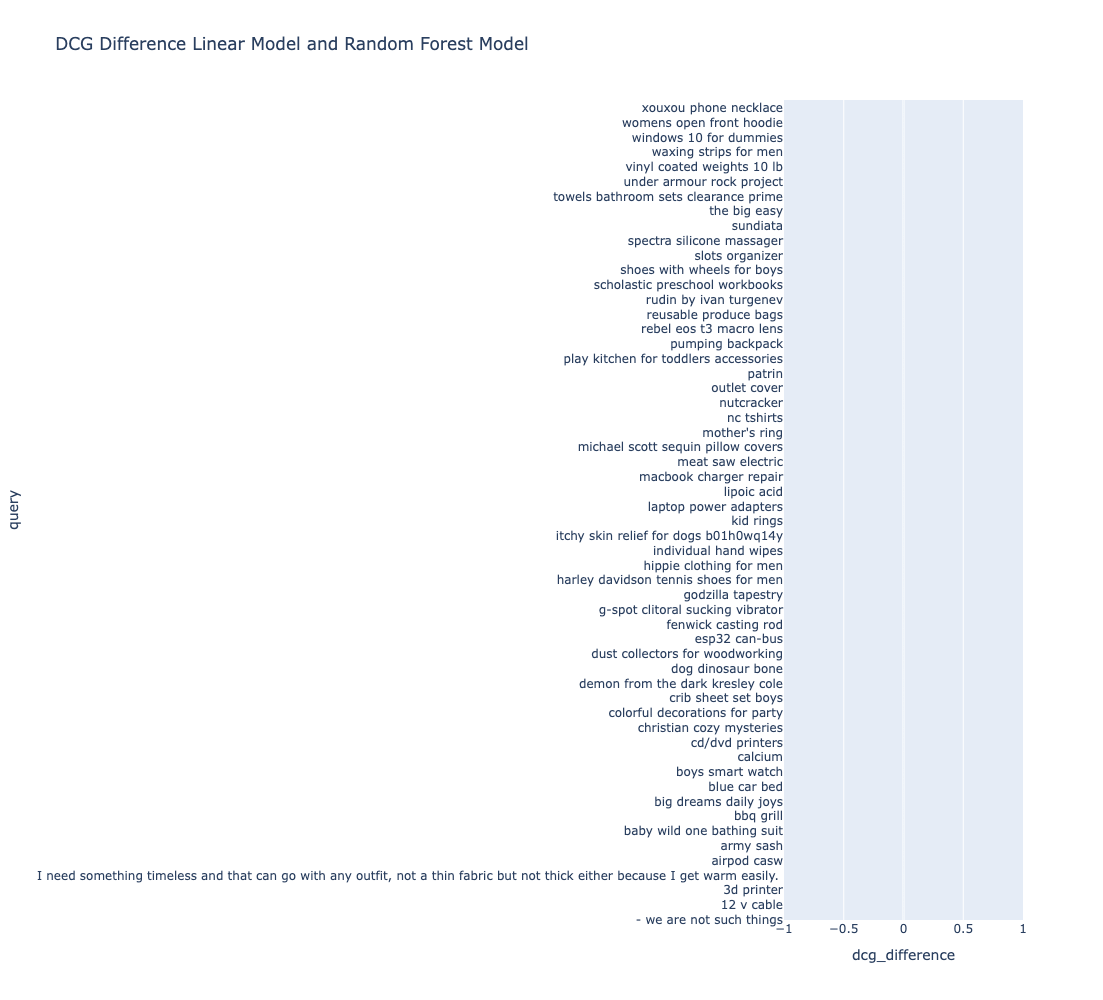

In [102]:
px.bar(df_metrics_merged, x="dcg_difference", y="query", orientation='h',
             hover_data=df_metrics_merged.columns,
             height=1000,
             title='DCG Difference Linear Model and Random Forest Model')